# Building a Movie Recommendation System with Clustering and Content-Based Filtering
## Introduction
In today's vast entertainment landscape, finding the perfect movie to watch can be overwhelming. With thousands of films available across various streaming platforms, an intelligent recommendation system is essential to guide users toward movies that match their preferences.

This project aims to build a hybrid movie recommendation system using a combination of K-Means clustering and content-based filtering. By leveraging machine learning techniques and natural language processing, we enhance movie suggestions by grouping films with similar attributes while also analyzing textual descriptions and genre similarities.

Through this approach, users receive highly relevant recommendations—helping them discover hidden gems beyond the usual top-rated films.

## About the Dataset: IMDb Top 5000 Movies
This project utilizes the IMDb Top 5000 Movies dataset, which consists of highly-rated films from IMDb, including crucial metadata like title, year, rating, votes, duration, genres, directors, and writers. The dataset serves as the foundation for building a movie recommendation system, leveraging clustering and content-based filtering techniques.

In [1]:
# Installing neccessary libraries here
! pip install pandas
! pip install numpy
! pip install scikit-learn
! pip install matplotlib
! pip install seaborn

In [2]:
#Importing necessary libraries
import os
import pandas as pd
import numpy as np
import ast  # for parsing genre strings
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Load the movie metadata CSV file

df = pd.read_csv(r"C:\Users\navya\Downloads\results_with_crew.csv")

In [4]:
#checking all the columns from datasets
df.columns

Index(['tconst', 'primaryTitle', 'startYear', 'rank', 'averageRating',
       'numVotes', 'runtimeMinutes', 'directors', 'writers', 'genres',
       'IMDbLink', 'Title_IMDb_Link'],
      dtype='object')

In [5]:
# We only need title, genres, vote_average, and popularity for this project
movies = df[['primaryTitle', 'genres', 'averageRating', 'rank']].copy()

In [6]:
# Drop rows with missing values in important columns
movies = movies.dropna(subset=['genres', 'averageRating', 'rank'])

In [7]:
#Extract genre names from JSON-like string
def parse_genres(genre_str):
    """Converts a string of genre dictionaries into a list of genre names."""
    try:
        genres = ast.literal_eval(genre_str)
        return [g['name'] for g in genres]
    except:
        return []

# Apply the parsing function to each row
movies['genre_list'] = movies['genres'].str.split(', ')

In [8]:
from sklearn.preprocessing import StandardScaler

# Select relevant numeric features
final_features = movies[['averageRating', 'rank']]  # Add other numeric features if available

# Apply scaling
scaler = StandardScaler()
final_features = scaler.fit_transform(final_features)

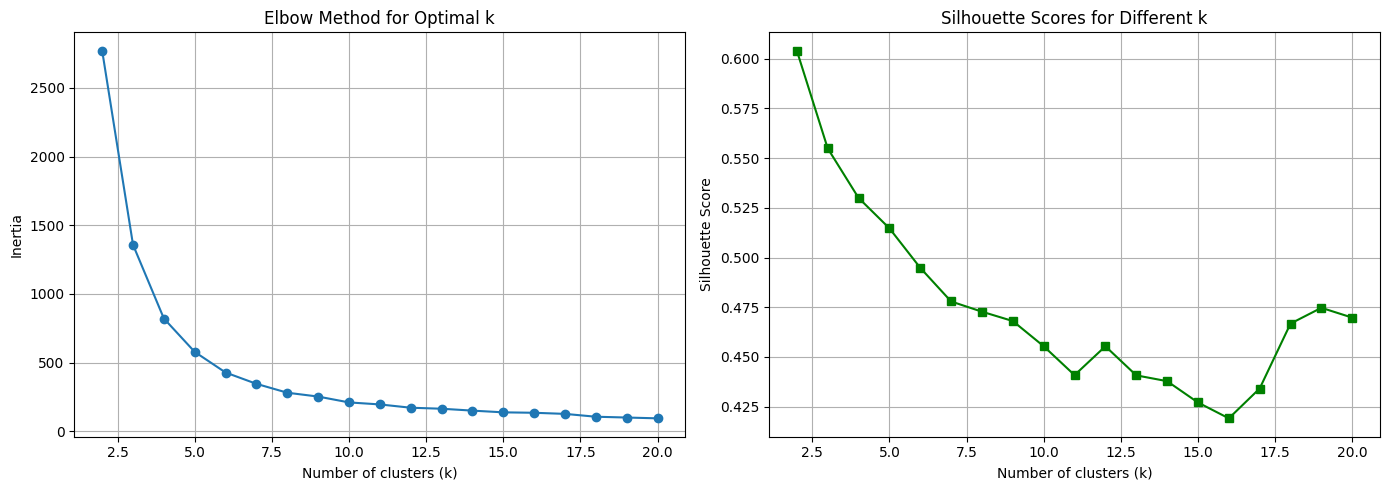

In [9]:
inertia_values = []
silhouette_scores = []
k_values = range(2, 21)

for k in k_values:
    kmeans_model = KMeans(n_clusters=k, random_state=42)
    kmeans_model.fit(final_features)
    inertia_values.append(kmeans_model.inertia_)
    silhouette_scores.append(silhouette_score(final_features, kmeans_model.labels_))

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(k_values, inertia_values, marker='o')
axs[0].set_title('Elbow Method for Optimal k')
axs[0].set_xlabel('Number of clusters (k)')
axs[0].set_ylabel('Inertia')
axs[0].grid(True)

axs[1].plot(k_values, silhouette_scores, marker='s', color='green')
axs[1].set_title('Silhouette Scores for Different k')
axs[1].set_xlabel('Number of clusters (k)')
axs[1].set_ylabel('Silhouette Score')
axs[1].grid(True)

plt.tight_layout()
plt.show()

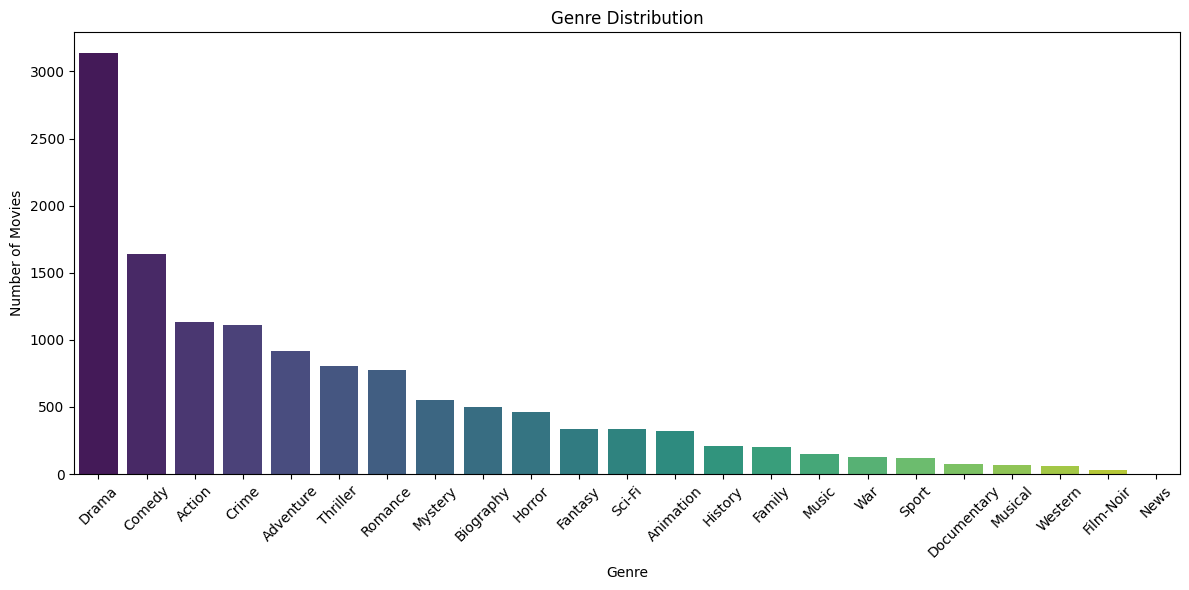

In [10]:
genre_counts = movies['genre_list'].explode().value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, hue=genre_counts.index, palette='viridis', legend=False)
plt.title('Genre Distribution')
plt.xticks(rotation=45)
plt.ylabel('Number of Movies')
plt.xlabel('Genre')
plt.tight_layout()
plt.show()

In [11]:
# This turns genre lists into binary features
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(movies['genre_list'])
genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_)

In [12]:
# We scale vote_average and popularity to range [0, 1]
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(movies[['averageRating', 'rank']])
scaled_df = pd.DataFrame(scaled_features, columns=['averageRating', 'rank'])

In [13]:
#Combine all features into one matrix
final_features = pd.concat([genre_df, scaled_df], axis=1)

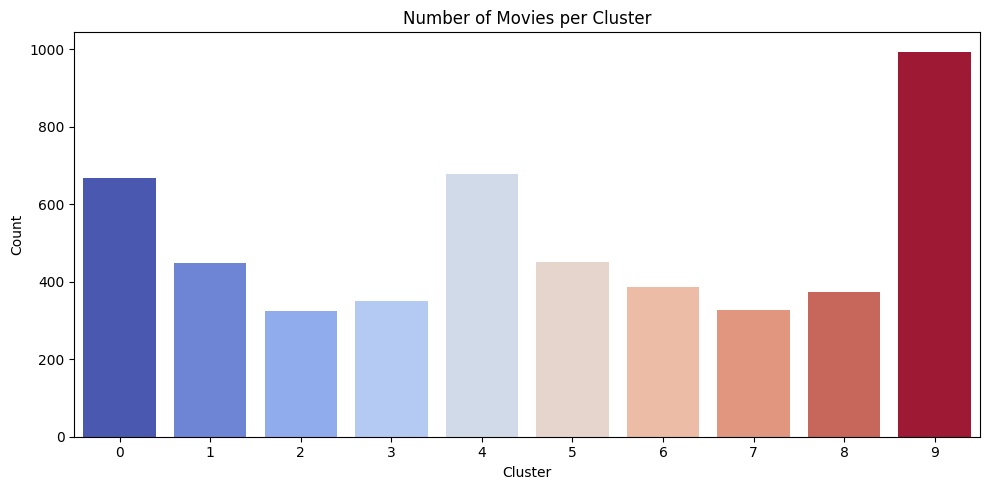

In [14]:
# Fit KMeans using chosen k (replace with optimal k from elbow plot)
optimal_k = 10
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
movies['cluster'] = kmeans.fit_predict(final_features)

# Plot how many movies per cluster
plt.figure(figsize=(10, 5))
sns.countplot(x=movies['cluster'], hue=movies['cluster'], palette='coolwarm', legend=False)
plt.title('Number of Movies per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Combine relevant features into a single text column for TF-IDF analysis
movies['combined_features'] = movies['primaryTitle'] + ' ' + movies['genre_list'].apply(lambda x: ' '.join(x))

# Convert text data into numerical vectors using TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
feature_matrix = tfidf.fit_transform(movies['combined_features'])

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(feature_matrix)

def recommend_movies(movie_title, n=5):
    """
    Recommend similar movies using a hybrid approach: clustering + content-based filtering.
    
    Parameters:
        movie_title (str): Title of the movie to base recommendations on.
        n (int): Number of similar movies to return.
        
    Returns:
        pd.DataFrame: Top N recommended movies in the same cluster with high similarity.
    """
    # Lowercase comparison for robust matching
    target = movies[movies['primaryTitle'].str.lower() == movie_title.lower()]
    
    if target.empty:
        return f"Movie titled '{movie_title}' not found in dataset."
    
    # Get cluster of target movie
    cluster_id = target['cluster'].values[0]
    
    # Filter movies from the same cluster
    cluster_movies = movies[movies['cluster'] == cluster_id]
    
    # Find cosine similarity within the cluster
    target_index = target.index[0]
    similarity_scores = similarity_matrix[target_index]

    # Sort by similarity within the cluster
    cluster_movies['similarity'] = similarity_scores[movies.index.isin(cluster_movies.index)]
    recommended_movies = cluster_movies.sort_values(by=['similarity', 'averageRating', 'rank'], ascending=False)

    # Remove the input movie and return top N recommendations
    return recommended_movies[recommended_movies['primaryTitle'].str.lower() != movie_title.lower()][['primaryTitle', 'averageRating', 'rank']].head(n)


In [16]:
# Example usage
movie_name = "Ice Age"
recommended_movies_df = recommend_movies(movie_name, n=5)

print(f"Recommended movies similar to '{movie_name}':")
print(recommended_movies_df)


Recommended movies similar to 'Ice Age':
                        primaryTitle  averageRating  rank
3599           Ice Age: The Meltdown            6.8  3600
3203  Ice Age: Dawn of the Dinosaurs            6.9  3204
4413      Ice Age: Continental Drift            6.5  4414
3013           The Croods: A New Age            6.9  3014
73                                Up            8.3    74


C:\Users\navya\AppData\Local\Temp\ipykernel_17404\2586981542.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_movies['similarity'] = similarity_scores[movies.index.isin(cluster_movies.index)]


## Conclusion
This project successfully builds a hybrid movie recommendation system that combines K-Means clustering and content-based filtering using TF-IDF and cosine similarity. By leveraging both structured (numerical) and unstructured (text) data, the system provides personalized movie suggestions that go beyond simple popularity-based recommendations.

**Key Takeaways**
- Clustering Groups Similar Movies: K-Means effectively categorizes movies into meaningful clusters.
- Content-Based Filtering Enhances Precision: TF-IDF and cosine similarity ensure genre, theme, and plot relevance.
- Improved Recommendation Accuracy: By merging clustering and content similarity, recommendations align better with user preferences.